Load Environment and Connection to DataBase

In [2]:
import os
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Load .env file
load_dotenv()

PGHOST     = os.getenv("PGHOST")
PGPORT     = os.getenv("PGPORT", "5432")
PGDATABASE = os.getenv("PGDATABASE")
PGUSER     = os.getenv("PGUSER")
PGPASSWORD = os.getenv("PGPASSWORD")
PGSSL      = os.getenv("PGSSL", "require")

assert PGHOST and PGDATABASE and PGUSER and PGPASSWORD, "❌ Missing DB env vars. Check your .env file!"

# Build SQLAlchemy engine
engine = create_engine(
    f"postgresql+psycopg2://{PGUSER}:{PGPASSWORD}@{PGHOST}:{PGPORT}/{PGDATABASE}?sslmode={PGSSL}",
    pool_pre_ping=True
)

# Query directly from staging_measurements
query = """
SELECT time, axis1, axis2, axis3, axis4,
       axis5, axis6, axis7, axis8
FROM staging_measurements
"""

# Load into DataFrame
df_train = pd.read_sql(query, engine)

# Ensure datetime and sort
df_train['time'] = pd.to_datetime(df_train['time'])
df_train.sort_values('time', inplace=True)

# Convert time to numeric (seconds since start)
df_train['time_numeric'] = (df_train['time'] - df_train['time'].min()).dt.total_seconds()

# Save to CSV
df_train.to_csv("Data/Training_data.csv", index=False)

print("✅ Data exported from staging_measurements to Training_data.csv")
print(df_train.head())


✅ Data exported from staging_measurements to Training_data.csv
                              time  axis1  axis2  axis3  axis4  axis5  axis6  \
0 2022-10-17 12:18:23.660000+00:00    0.0    0.0    0.0    0.0    0.0    0.0   
1 2022-10-17 12:18:25.472000+00:00    0.0    0.0    0.0    0.0    0.0    0.0   
2 2022-10-17 12:18:27.348000+00:00    0.0    0.0    0.0    0.0    0.0    0.0   
3 2022-10-17 12:18:29.222000+00:00    0.0    0.0    0.0    0.0    0.0    0.0   
4 2022-10-17 12:18:31.117000+00:00    0.0    0.0    0.0    0.0    0.0    0.0   

   axis7  axis8  time_numeric  
0    0.0    0.0         0.000  
1    0.0    0.0         1.812  
2    0.0    0.0         3.688  
3    0.0    0.0         5.562  
4    0.0    0.0         7.457  


## Train Linear Regression Models and Analyze Residuals

In [7]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 20)

DATA_DIR = Path("Data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

AXES = ['axis1','axis2','axis3','axis4','axis5','axis6','axis7','axis8']

# --- Load training data ---
train_path = DATA_DIR / "Training_data.csv"
if not train_path.exists():
    train_path = Path("Training_data.csv")  # fallback if file not in Data folder
assert train_path.exists(), "❌ Training_data.csv not found. Please export it first."

df_train = pd.read_csv(train_path)

# Force-convert 'time' to datetime
df_train['time'] = pd.to_datetime(df_train['time'], errors='coerce')

# Sort by time
df_train = df_train.sort_values('time').reset_index(drop=True)

# Ensure time_numeric exists; if not, create it
if 'time_numeric' not in df_train.columns:
    df_train['time_numeric'] = (df_train['time'] - df_train['time'].min()).dt.total_seconds()

# Drop rows with missing values
df_train = df_train.dropna(subset=['time_numeric'] + AXES)

# --- Estimate sampling interval ---
time_diffs = df_train['time'].diff().dt.total_seconds()
sample_interval_sec = float(np.nanmedian(time_diffs))
print(f"Estimated sampling interval: {sample_interval_sec:.3f} seconds")

# --- Fit models (Time -> Axis) ---
models = {}
slopes = {}
intercepts = {}
residuals_dict = {}

X = df_train[['time_numeric']].values

for axis in AXES:
    y = df_train[axis].values
    mdl = LinearRegression()
    mdl.fit(X, y)
    models[axis] = mdl
    slopes[axis] = float(mdl.coef_[0])
    intercepts[axis] = float(mdl.intercept_)

    y_pred = mdl.predict(X)
    residuals_dict[axis] = y - y_pred

# --- Summaries ---
model_summary = pd.DataFrame({
    "axis": AXES,
    "slope": [slopes[a] for a in AXES],
    "intercept": [intercepts[a] for a in AXES]
}).sort_values("axis")

residual_stats = pd.DataFrame({
    "axis": AXES,
    "residual_mean": [float(np.mean(residuals_dict[a])) for a in AXES],
    "residual_std":  [float(np.std(residuals_dict[a], ddof=0)) for a in AXES],
}).sort_values("axis")

# Save artifacts
model_summary.to_csv(DATA_DIR / "model_params.csv", index=False)
residual_stats.to_csv(DATA_DIR / "residual_stats.csv", index=False)

print("\n📊 Model parameters (slopes/intercepts):")
print(model_summary)

print("\n📊 Residual stats (mean/std):")
print(residual_stats)

print("\n✅ Ready: models, residuals_dict, model_params.csv, residual_stats.csv")


Estimated sampling interval: 1.891 seconds

📊 Model parameters (slopes/intercepts):
    axis         slope  intercept
0  axis1 -1.176729e-07   0.730542
1  axis2  2.194203e-06   3.523886
2  axis3 -5.777186e-07   2.733898
3  axis4  3.890034e-07   0.604357
4  axis5  8.381178e-08   0.951103
5  axis6  4.744455e-07   0.580077
6  axis7  5.537186e-07   0.847563
7  axis8  8.499989e-08   0.098748

📊 Residual stats (mean/std):
    axis  residual_mean  residual_std
0  axis1  -2.292536e-17      2.162091
1  axis2   2.751043e-16      6.879688
2  axis3  -1.146268e-17      5.111819
3  axis4   7.450741e-17      1.574851
4  axis5  -1.318208e-16      2.100159
5  axis6  -1.432835e-17      1.815442
6  axis7  -1.031641e-16      2.166746
7  axis8   0.000000e+00      0.423065

✅ Ready: models, residuals_dict, model_params.csv, residual_stats.csv


## Visualize fits & residuals

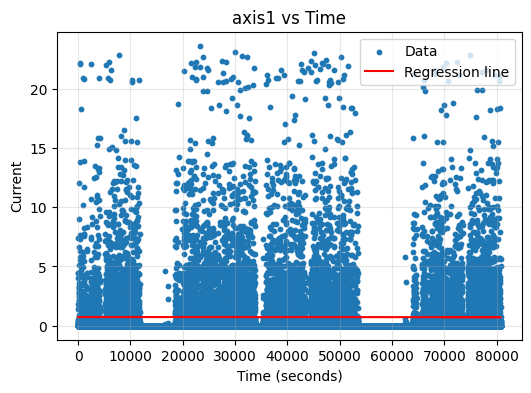

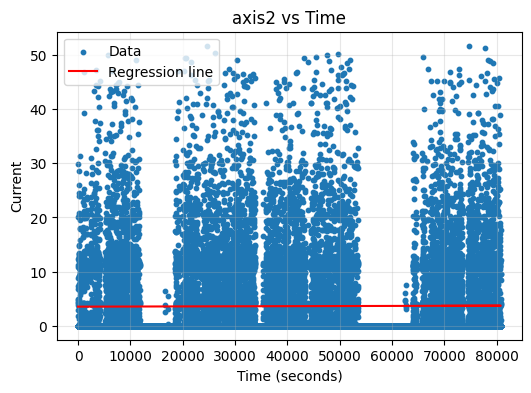

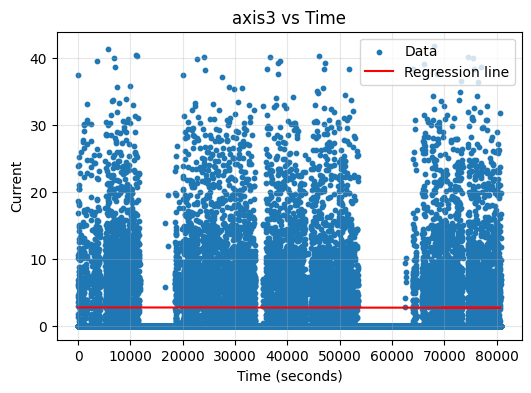

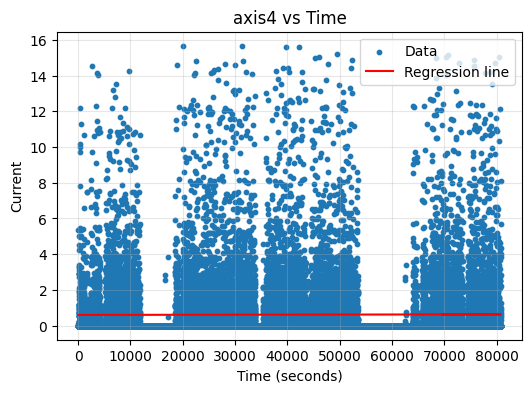

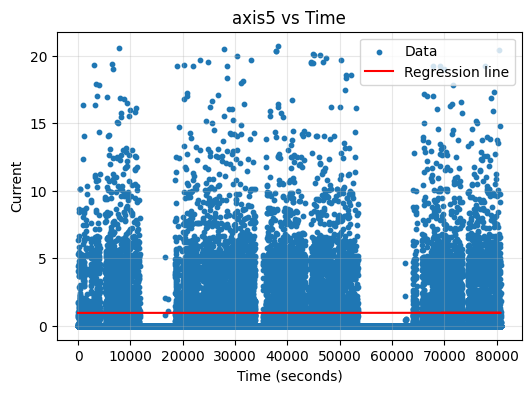

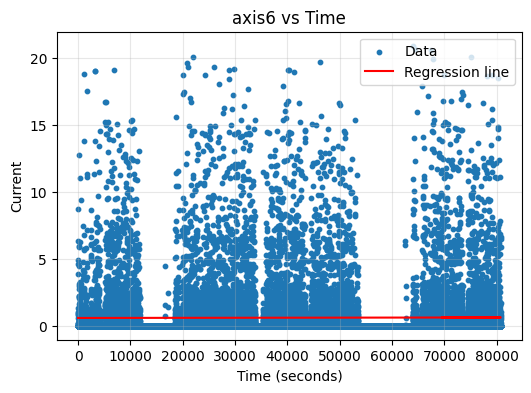

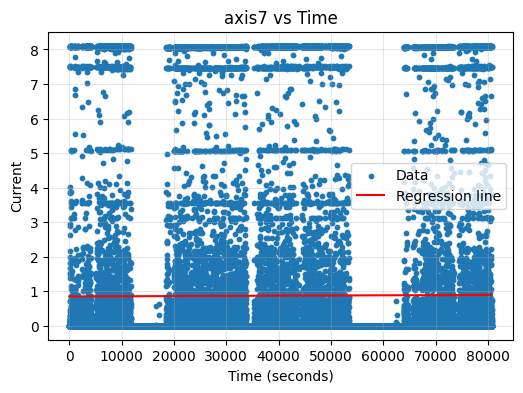

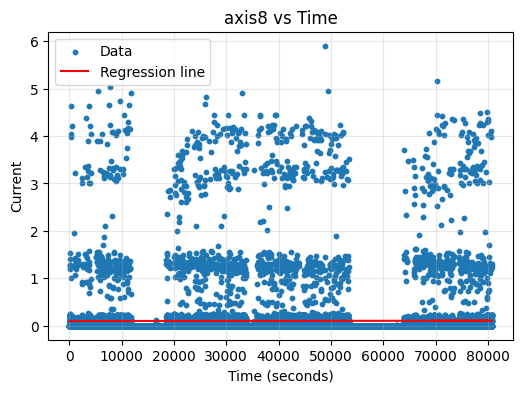

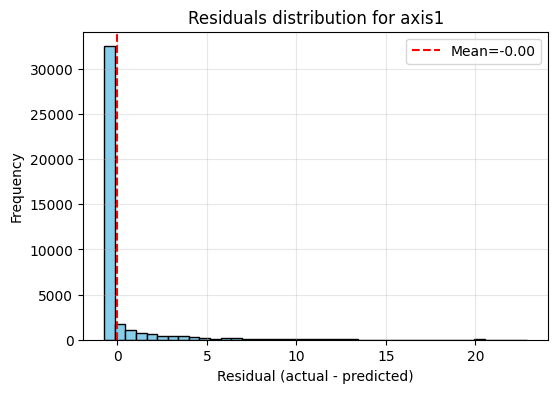

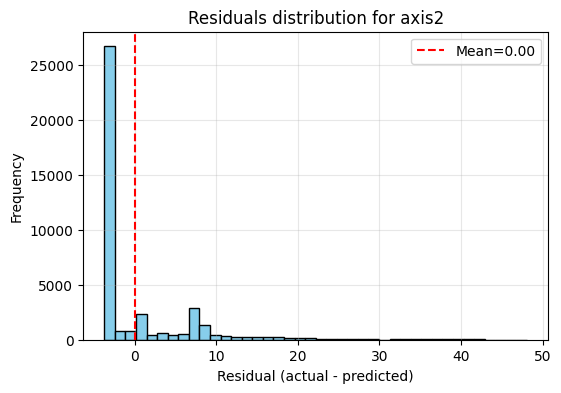

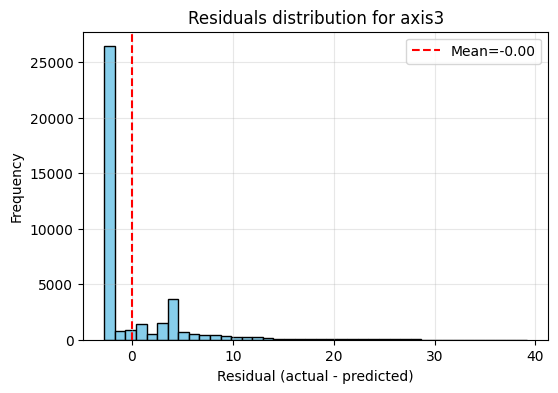

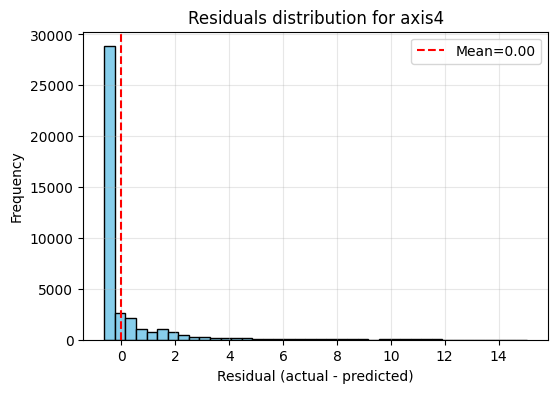

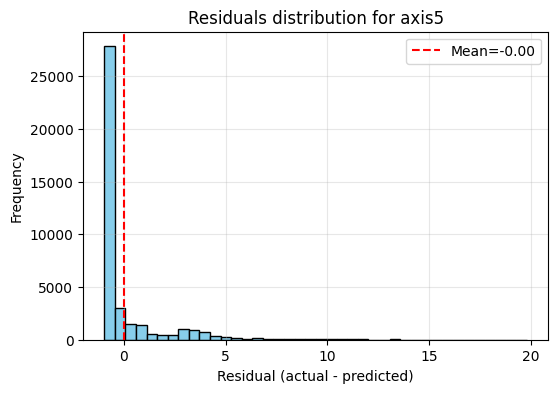

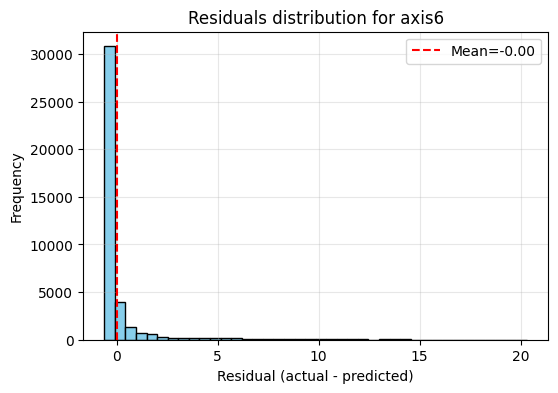

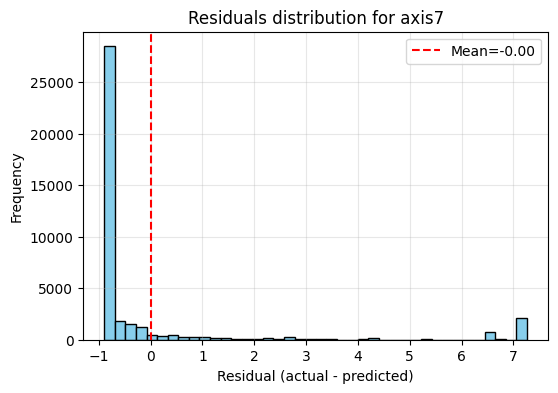

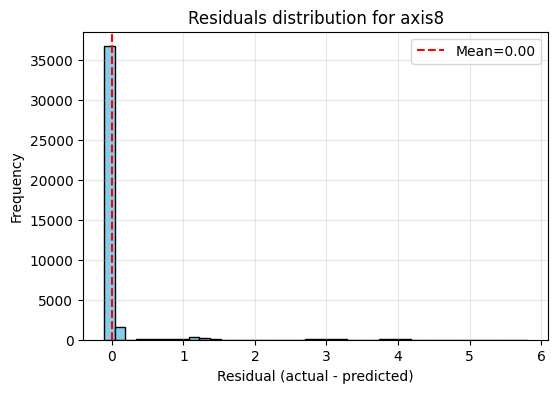

In [8]:
# --- Step 2: Visualization ---

# 1) Plot scatter + regression line for each axis
for axis in AXES:
    y = df_train[axis].values
    X = df_train[['time_numeric']].values
    y_pred = models[axis].predict(X)
    
    plt.figure(figsize=(6,4))
    plt.scatter(df_train['time_numeric'], y, label='Data', s=10)
    plt.plot(df_train['time_numeric'], y_pred, color='red', label='Regression line')
    plt.title(f'{axis} vs Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Current')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# 2) Plot histograms of residuals
for axis in AXES:
    res = residuals_dict[axis]
    
    plt.figure(figsize=(6,4))
    plt.hist(res, bins=40, color='skyblue', edgecolor='black')
    plt.axvline(np.mean(res), color='red', linestyle='--', label=f"Mean={np.mean(res):.2f}")
    plt.title(f'Residuals distribution for {axis}')
    plt.xlabel('Residual (actual - predicted)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


## Discover thresholds (MinC, MaxC)

In [9]:
# --- Step 3: Threshold Discovery ---

def discover_thresholds(residuals_dict, method="percentile",
                        minc_q=97.5, maxc_q=99.5,
                        k_min=2.5, k_max=3.5):
    rows = []
    minc_by_axis = {}
    maxc_by_axis = {}
    
    for axis, res in residuals_dict.items():
        res = np.asarray(res)
        pos = res[res > 0]   # focus on positive residuals only
        if len(pos) == 0:
            pos = res  # fallback if all values <= 0

        if method == "percentile":
            MinC = float(np.percentile(pos, minc_q))
            MaxC = float(np.percentile(pos, maxc_q))
        elif method == "std":
            mu = float(np.mean(pos))
            sigma = float(np.std(pos, ddof=0))
            MinC = mu + k_min * sigma
            MaxC = mu + k_max * sigma
        else:
            raise ValueError("method must be 'percentile' or 'std'")
        
        minc_by_axis[axis] = MinC
        maxc_by_axis[axis] = MaxC
        rows.append({"axis": axis, "MinC": MinC, "MaxC": MaxC})
    
    return pd.DataFrame(rows), minc_by_axis, maxc_by_axis

# --- Calculate thresholds both ways ---
thr_table_pct, MinC_pct, MaxC_pct = discover_thresholds(
    residuals_dict, method="percentile", minc_q=97.5, maxc_q=99.5
)

thr_table_std, MinC_std, MaxC_std = discover_thresholds(
    residuals_dict, method="std", k_min=2.5, k_max=3.5
)

print("📊 Percentile-based thresholds:")
display(thr_table_pct)

print("📊 Std-based thresholds:")
display(thr_table_std)

# Save for later / README
thr_table_pct.to_csv(DATA_DIR / "thresholds_percentile.csv", index=False)
thr_table_std.to_csv(DATA_DIR / "thresholds_std.csv", index=False)


📊 Percentile-based thresholds:


,axis,MinC,MaxC
0,axis1,14.484867,20.966863
1,axis2,31.475375,41.795166
2,axis3,23.597567,30.227050
3,axis4,10.147074,13.008520
4,axis5,11.007934,16.092185
5,axis6,12.062241,16.162987
6,axis7,7.243831,7.255760
7,axis8,3.821231,4.250260


📊 Std-based thresholds:


,axis,MinC,MaxC
0,axis1,12.922450,16.784425
1,axis2,27.933964,35.763480
2,axis3,20.561974,26.383488
3,axis4,7.920240,10.342461
4,axis5,9.984031,12.809243
5,axis6,10.110378,13.305862
6,axis7,11.445049,14.359989
7,axis8,2.879637,3.839790
